In [1]:
# Generating time Axis
import numpy as np
samplingFrequency  = 500; # samplingTime = 0.002
timeAxis = np.linspace(0, samplingFrequency, samplingFrequency + 1) / samplingFrequency

In [2]:
# Creating a Gabor dictionary
import waveletDictionary as gabor
nbFrequencies = 30
dictionary = gabor.waveletDictionary(timeAxis, nbFrequencies)

building wavelet dictionary ...
dictionary is ready!


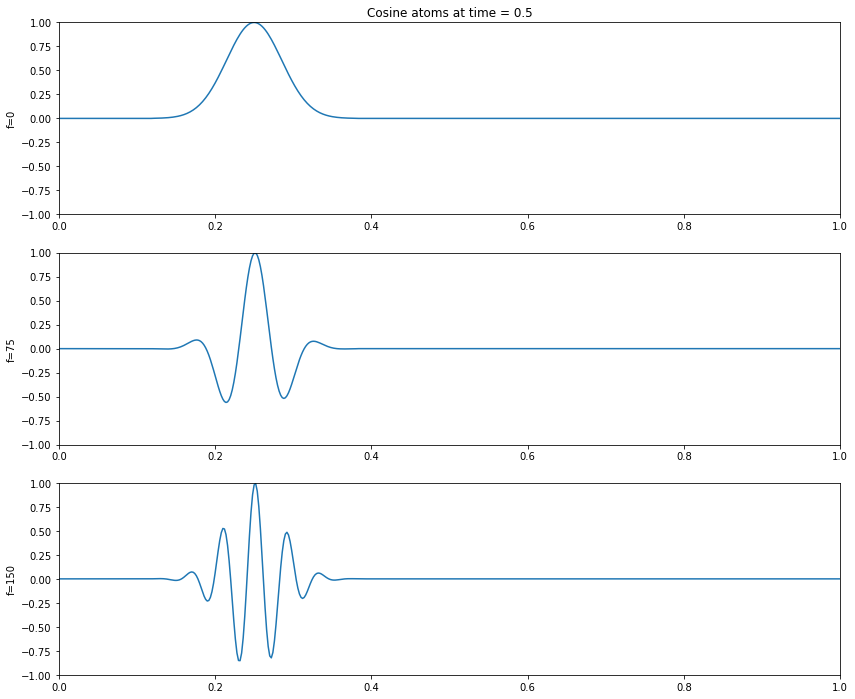

In [3]:
# Plotting some atoms
# for this case we plot three atoms coresponding to time = 0.5s, frequencies = {0Hz, 75Hz, 15Hz}, cosine phase

%matplotlib inline
import matplotlib.pyplot as plt
centerTime = 0.5
centerTimeIdx = 125 # this can be obtained from centerTime
nbBasisSignals = 2 * nbFrequencies + 1
plottedFrequencies = np.array([0, 75, 150])
freqOffsets = np.array([0, 29, 59]) # this can be obtained from plottedFrequencies
                                    # 0Hz -> 0, cos(f) -> (f/f_0)*2 -1 , sin(f) -> (f/f_0)*2, in this example f_0 = 5Hz 
plt.figure(figsize = (14, 12))
nbPlottedFrequencies = freqOffsets.size
for i in range(nbPlottedFrequencies):
    basisElementIdx = nbBasisSignals * centerTimeIdx + freqOffsets[i]   
    basisElement = dictionary[:, basisElementIdx]
    basisElement = basisElement.todense()
    plt.subplot(nbPlottedFrequencies, 1, i + 1)
    plt.plot(timeAxis, basisElement)
    if (i == 0):
        plt.title("Cosine atoms at time = %s" % centerTime)
    plt.xlim(0, 1)
    plt.ylim(-1, 1)
    plt.ylabel("f=%s" % plottedFrequencies[i])
plt.show()

In [4]:
#Generate testing signal
amp = 0.5 * np.sin(11 * timeAxis) + 1
theta = 30 * np.sin(5 * timeAxis)
testingSignal = np.multiply(amp, np.sin(theta))

In [5]:
#Solve the basis pursuit problem 
from cvxpy import *
gamma = Parameter(sign="positive")
gamma.value = 1
nbAtoms = dictionary.shape[1]
x = Variable(nbAtoms)
cost = sum_squares(dictionary * x - testingSignal) + gamma * norm(x, 1)
prob = Problem(Minimize(cost))
opt_val = prob.solve()
solution = x.value

In [6]:
#Reoptimize problem over nonzero coefficients
useful_indices = np.where(np.absolute(solution) > 1e-5)
compact_dictionary = dictionary[:, useful_indices[0]]
from scipy.sparse.linalg import lsqr
solution_opt, istop, itn, r1norm = lsqr(compact_dictionary, testingSignal)[: 4]

In [7]:
#recoveredSignal = dictionary.dot(solution)
recoveredSignal = compact_dictionary.dot(solution_opt)

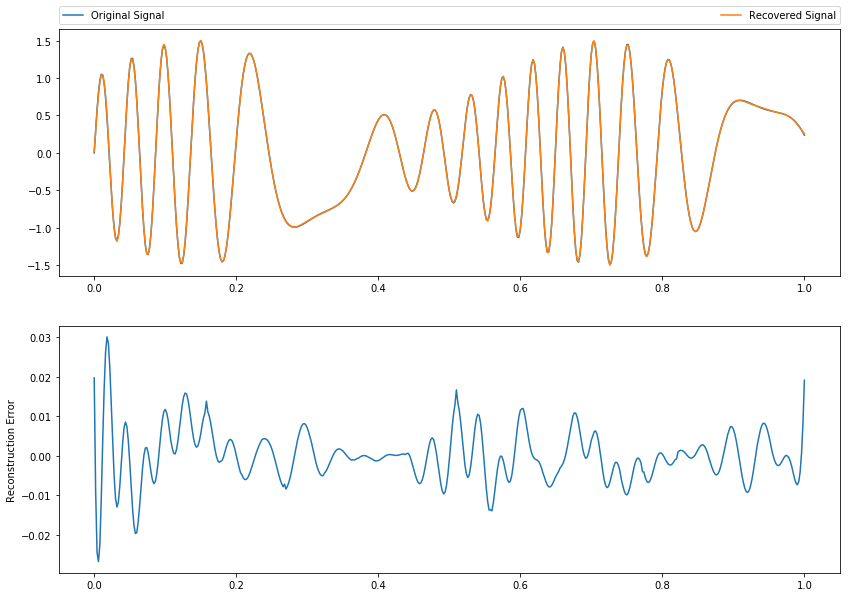

In [8]:
# Comparing reconstructed signal with the original one
plt.figure(figsize = (14, 10))
plt.subplot(2, 1, 1)
plt.plot(timeAxis, testingSignal, label = "Original Signal")
plt.plot(timeAxis, recoveredSignal, label = "Recovered Signal")
plt.legend(bbox_to_anchor = (0., 1.02, 1., .102), loc=3, ncol=2, mode="expand", borderaxespad=0.)
plt.subplot(2, 1, 2)
plt.plot(timeAxis, recoveredSignal - testingSignal)
plt.ylabel("Reconstruction Error")
plt.show()

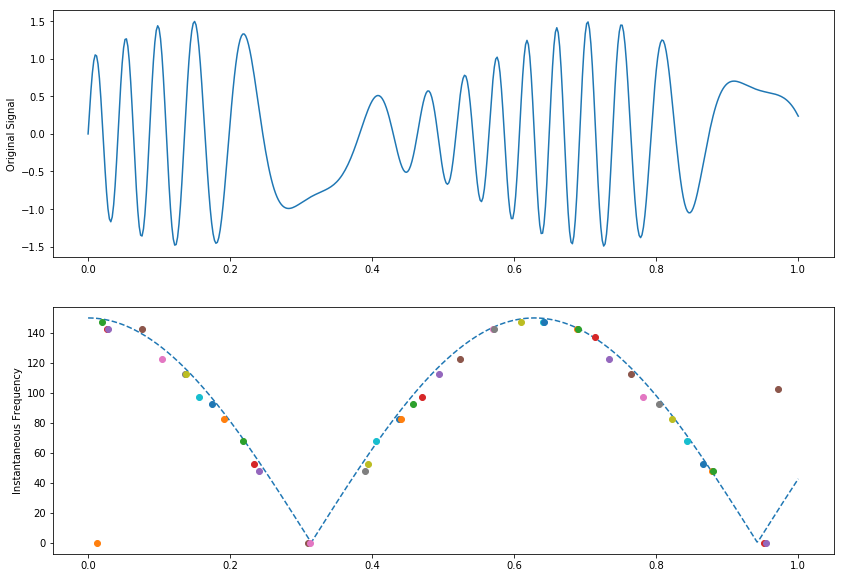

In [23]:
# Plot original signal and its instantaneous frequency
plt.figure(figsize = (14, 10))
plt.subplot(2, 1, 1)
plt.plot(timeAxis, testingSignal)
plt.ylabel("Original Signal")
plt.subplot(2, 1, 2)
# base frequency equal to 5, it should be a parameter of the gabor dictionary
baseFrequency = 5
plt.plot(timeAxis, 150 * np.abs(np.cos(5 * timeAxis)), "--") 
plt.ylabel("Instantaneous Frequency")
for i in range(timeAxis.size):
    if (np.abs(solution[i * nbBasisSignals]) > 1e-5):
        plt.plot(timeAxis[i], 0, 'o')
    for j in range(1, nbBasisSignals, 2):
        if ((np.abs(solution[i * nbBasisSignals + j]) > 1e-5) | (np.abs(solution[i * nbBasisSignals + j + 1]) > 1e-5)):
            plt.plot(timeAxis[i], baseFrequency * j / 2, 'o')
plt.show()